In [45]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table
from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import RectangleSkyRegion, RectanglePixelRegion
import cmasher as cmr

data_dir = os.getenv("DATADIR")
vizier = Vizier()
vizier.ROW_LIMIT = -1

def get_anna_coords(r,d,optical_hdu):
    x,y = WCS(optical_hdu,naxis=2).all_world2pix(r,d,0)
    return x,y

# MCPS Based SFH Maps
table_name_lmc = 'J/AJ/138/1243/table2' # Harris+ 2009
table_name_smc = 'J/AJ/127/1531/table2' # Harris+ 2004
# Open catalogs in vizier
lmc = vizier.get_catalogs(table_name_lmc)[0].to_pandas()
smc = vizier.get_catalogs(table_name_smc)[0].to_pandas()  
# Get their coordinates
lmc_sfh_coord =  SkyCoord(lmc['RAJ2000'], lmc['DEJ2000'], unit=('hourangle', 'deg'), frame='fk5')
smc_sfh_coord =  SkyCoord(smc['RAJ2000'], smc['DEJ2000'], unit=('hourangle', 'deg'), frame='fk5')
# For plotting, their cells are typically 12 arcmin on a side
cell_radius = 12 * u.arcmin

# Get candidate catalog
df = pd.read_csv(data_dir+'0_SUMS_Catalogs/FinalCatalogs/SUMS_UV_Candidate_Catalog.csv')
# Separate SMC and LMC candidates
smc_cand = df[df.RA < 30].reset_index(drop=True)
lmc_cand = df[df.RA > 30].reset_index(drop=True)
# Get their coordinates on Anna O'Grady's images of the MCs
smc_coords = SkyCoord(smc_cand.RA, smc_cand.Dec, unit='deg')
lmc_coords = SkyCoord(lmc_cand.RA, lmc_cand.Dec, unit='deg')
lmc_hdu = fits.open(data_dir+'4_MagellanicClouds/Photos/anna_lmc.fits')[0]
smc_hdu = fits.open(data_dir+'4_MagellanicClouds/Photos/anna_smc.fits')[0]
lmc_img = lmc_hdu.data[0]
smc_img = smc_hdu.data[0]
lmc_wcs = WCS(lmc_hdu,naxis=2)
smc_wcs = WCS(smc_hdu,naxis=2)
smc_x,smc_y = get_anna_coords(smc_cand.RA, smc_cand.Dec, smc_hdu)
lmc_x,lmc_y = get_anna_coords(lmc_cand.RA, lmc_cand.Dec, lmc_hdu)

# For each candidate, find nearest SFH region
for ind, row in lmc_cand.iterrows():
    row_coord = SkyCoord(row['RA'], row['Dec'], unit='deg', frame='fk5')
    dists = row_coord.separation(lmc_sfh_coord).arcmin
    nearest_ind = np.argmin(dists)

    lmc_cand.loc[ind, 'Nearest_SFH_Reg'] = lmc.loc[nearest_ind, 'Reg']
    lmc_cand.loc[ind, 'Nearest_SFH_Dist_arcmin'] = np.min(dists)

for ind, row in smc_cand.iterrows():
    row_coord = SkyCoord(row['RA'], row['Dec'], unit='deg', frame='fk5')
    dists = row_coord.separation(smc_sfh_coord).arcmin
    nearest_ind = np.argmin(dists)

    smc_cand.loc[ind, 'Nearest_SFH_Reg'] = smc.loc[nearest_ind, 'Region'] # SMC uses 'Region' not 'Reg'
    smc_cand.loc[ind, 'Nearest_SFH_Dist_arcmin'] = np.min(dists)

# Roughly, stripped stars live 10-100 Myr after star formation
# 100 million years = 1e8 years
stripped_star_age_range = [7,8]

# For LMC
# Get columns that begin with 'SFR':
sfr_cols = [col for col in lmc.columns if col.startswith('SFR')]

lmc_cells = [] # Pixel regions
table = [] # Container for region properties
for ind,region in enumerate(np.unique(lmc.Reg)):
    # Group by the region and take the first one to get the coordinate
    first_row = lmc.loc[lmc.Reg==region].iloc[0]
    coord =  SkyCoord(first_row['RAJ2000'], first_row['DEJ2000'], unit=('hourangle', 'deg'), frame='fk5')
    # Define the pixel region based on what we know about the cell size
    region_sky = RectangleSkyRegion(center=coord, width=cell_radius, height=cell_radius)
    region_pixel = region_sky.to_pixel(lmc_wcs)
    # Save it to plot with later
    lmc_cells.append(region_pixel)
    # By distance to nearest region
    n_candidates_in_region = lmc_cand[lmc_cand['Nearest_SFH_Reg'] == region].shape[0] 
    # How much older SFR is there?
    older_sfr = lmc.loc[(lmc.Reg==region) & (lmc.logAge > stripped_star_age_range[1]), sfr_cols].sum().sum()
    # How much younger SFR is there?
    younger_sfr = lmc.loc[(lmc.Reg==region) & (lmc.logAge < stripped_star_age_range[0]), sfr_cols].sum().sum()
    # 10-100 Myr SFR
    target_sfr = lmc.loc[(lmc.Reg==region) & (lmc.logAge >= stripped_star_age_range[0]) & (lmc.logAge <= stripped_star_age_range[1]), sfr_cols].sum().sum()
    # Save to dict
    table.append({'Region': region,
                'RA': first_row['RAJ2000'],
                'Dec': first_row['DEJ2000'],
                'Younger_SFR': younger_sfr,
                'Older_SFR': older_sfr,
                'Target_SFR': target_sfr,   
                'N_Candidates': n_candidates_in_region})
# Concatenate
lmc_sfr = pd.DataFrame(table)

# Calculate fraction 
lmc_sfr['Total_SFR'] = lmc_sfr['Target_SFR'] + lmc_sfr['Older_SFR'] + lmc_sfr['Younger_SFR']
lmc_sfr['Younger_Percent'] = lmc_sfr['Younger_SFR'] / lmc_sfr['Total_SFR'] * 100
lmc_sfr['Target_Percent'] = lmc_sfr['Target_SFR'] / lmc_sfr['Total_SFR'] * 100
lmc_sfr['Old_Percent'] = lmc_sfr['Older_SFR'] / lmc_sfr['Total_SFR'] * 100

# Which type of SFR is dominant in each cell?
lmc_sfr.loc[(lmc_sfr['Target_SFR'] > lmc_sfr['Younger_SFR']) & (lmc_sfr['Target_SFR'] > lmc_sfr['Older_SFR']),'Dominant'] = 'Target'
lmc_sfr.loc[(lmc_sfr['Younger_SFR'] > lmc_sfr['Target_SFR']) & (lmc_sfr['Younger_SFR'] > lmc_sfr['Older_SFR']),'Dominant'] = 'Younger'
lmc_sfr.loc[(lmc_sfr['Older_SFR'] > lmc_sfr['Target_SFR']) & (lmc_sfr['Older_SFR'] > lmc_sfr['Younger_SFR']),'Dominant'] = 'Older'

# Grab only regions which overlap with candidates
lmc_cand_sfr = lmc_sfr[(lmc_sfr.N_Candidates != 0)]

# Repeat for SMC, slightly different column names
sfr_cols = [col for col in smc.columns if col.startswith('SFR')]

table = [] # Reset containers
smc_cells = [] # Pixel regions
for ind,region in enumerate(np.unique(smc.Region)):
    first_row = smc.loc[smc.Region==region].iloc[0]
    coord =  SkyCoord(first_row['RAJ2000'], first_row['DEJ2000'], unit=('hourangle', 'deg'), frame='fk5')
    region_sky = RectangleSkyRegion(center=coord, width=cell_radius, height=cell_radius)
    region_pixel = region_sky.to_pixel(smc_wcs)
    smc_cells.append(region_pixel)
    # By distance to nearest region
    n_candidates_in_region = smc_cand[smc_cand['Nearest_SFH_Reg'] == region].shape[0] 
    younger_sfr = smc.loc[(smc.Region==region) & (smc['O-Age'] < stripped_star_age_range[0]), sfr_cols].sum().sum()
    older_sfr = smc.loc[(smc.Region==region) & (smc['O-Age'] > stripped_star_age_range[1]), sfr_cols].sum().sum()
    target_sfr = smc.loc[(smc.Region==region) & (smc['O-Age'] >= stripped_star_age_range[0]) & (smc['O-Age'] <= stripped_star_age_range[1]), sfr_cols].sum().sum()

    # Save to dict
    table.append({'Region': region,
                'RA': first_row['RAJ2000'],
                'Dec': first_row['DEJ2000'],
                'Older_SFR': older_sfr,
                'Younger_SFR': younger_sfr,
                'Target_SFR': target_sfr,
                'N_Candidates': n_candidates_in_region})

smc_sfr = pd.DataFrame(table)
smc_sfr['Total_SFR'] = smc_sfr['Older_SFR'] + smc_sfr['Younger_SFR'] + smc_sfr['Target_SFR']
smc_sfr['Younger_Percent'] = smc_sfr['Younger_SFR'] / smc_sfr['Total_SFR'] * 100
smc_sfr['Target_Percent'] = smc_sfr['Target_SFR'] / smc_sfr['Total_SFR'] * 100
smc_sfr['Older_Percent'] = smc_sfr['Older_SFR'] / smc_sfr['Total_SFR'] * 100

# Which type of SFR is dominant in each cell?
smc_sfr.loc[(smc_sfr['Target_SFR'] > smc_sfr['Younger_SFR']) & (smc_sfr['Target_SFR'] > smc_sfr['Older_SFR']),'Dominant'] = 'Target'
smc_sfr.loc[(smc_sfr['Younger_SFR'] > smc_sfr['Target_SFR']) & (smc_sfr['Younger_SFR'] > smc_sfr['Older_SFR']),'Dominant'] = 'Younger'
smc_sfr.loc[(smc_sfr['Older_SFR'] > smc_sfr['Target_SFR']) & (smc_sfr['Older_SFR'] > smc_sfr['Younger_SFR']),'Dominant'] = 'Older'

# Grab only regions which overlap with candidates
smc_cand_sfr = smc_sfr[(smc_sfr.N_Candidates != 0)]


# Print some stats 
print(f'Number of candidates dominated by each SFH type for the LMC:')
lmc_target = lmc_cand_sfr[lmc_cand_sfr.Dominant == 'Target']
print(f'10-100 Myr: {lmc_target.N_Candidates.sum()} {lmc_target.N_Candidates.sum()/lmc_cand_sfr.N_Candidates.sum():.2%}')

lmc_very_young = lmc_cand_sfr[lmc_cand_sfr.Dominant == 'Younger']
print(f'<10 Myr: {lmc_very_young.N_Candidates.sum()} {lmc_very_young.N_Candidates.sum()/lmc_cand_sfr.N_Candidates.sum():.2%}')

lmc_old = lmc_cand_sfr[lmc_cand_sfr.Dominant == 'Older']
print(f'>100 Myr: {lmc_old.N_Candidates.sum()} {lmc_old.N_Candidates.sum()/lmc_cand_sfr.N_Candidates.sum():.2%}')

print(f'Is target SFH ever 0 for any region? {np.any(lmc_cand_sfr.Target_SFR < 1)}')

print(f'Were all candidates assigned to a region? {lmc_cand_sfr.N_Candidates.sum() == lmc_cand.shape[0]}')

print('')
print(f'Number of candidates dominated by each SFH type for the SMC:')

smc_target = smc_cand_sfr[smc_cand_sfr.Dominant == 'Target']
print(f'10-100 Myr: {smc_target.N_Candidates.sum()} {smc_target.N_Candidates.sum()/smc_cand_sfr.N_Candidates.sum():.2%}')

smc_very_young = smc_cand_sfr[smc_cand_sfr.Dominant == 'Younger']
print(f'<10 Myr: {smc_very_young.N_Candidates.sum()} {smc_very_young.N_Candidates.sum()/smc_cand_sfr.N_Candidates.sum():.2%}')

smc_old = smc_cand_sfr[smc_cand_sfr.Dominant == 'Older']
print(f'>100 Myr: {smc_old.N_Candidates.sum()} {smc_old.N_Candidates.sum()/smc_cand_sfr.N_Candidates.sum():.2%}')

print(f'Is target SFH ever 0 for any region? {np.any(smc_cand_sfr.Target_SFR < 1)}')

print(f'Were all candidates assigned to a region? {smc_cand_sfr.N_Candidates.sum() == smc_cand.shape[0]}')

Number of candidates dominated by each SFH type for the LMC:
10-100 Myr: 226 43.30%
<10 Myr: 128 24.52%
>100 Myr: 168 32.18%
Is target SFH ever 0 for any region? False
Were all candidates assigned to a region? True

Number of candidates dominated by each SFH type for the SMC:
10-100 Myr: 107 35.91%
<10 Myr: 102 34.23%
>100 Myr: 89 29.87%
Is target SFH ever 0 for any region? False
Were all candidates assigned to a region? True


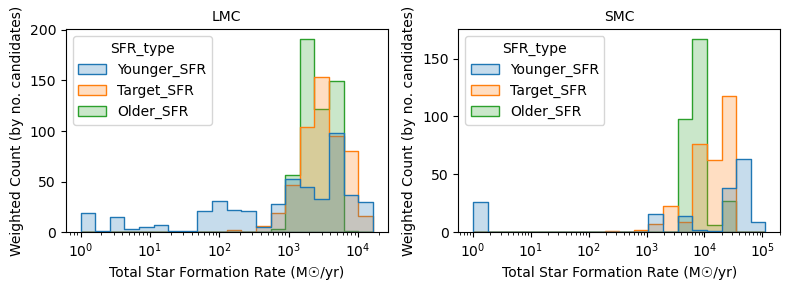

In [34]:
f, axes = plt.subplots(1,2,figsize=(8,3))

for i,df in enumerate([lmc_cand_sfr, smc_cand_sfr]):
    melted = df.melt(id_vars="N_Candidates",
                    value_vars=["Younger_SFR", "Target_SFR", "Older_SFR"],
                    var_name="SFR_type", value_name="SFR")

    sns.histplot(
        data=melted,
        x="SFR",
        weights="N_Candidates",
        hue="SFR_type",
        bins=20,
        element="step",
        common_norm=False,
        ax=axes[i],
        log_scale=(True, False)
    )
    axes[i].set_xlabel("Total Star Formation Rate (M☉/yr)",fontsize=10)
    axes[i].set_ylabel("Weighted Count (by no. candidates)",fontsize=10)
    axes[i].set_title("LMC" if i==0 else "SMC", fontsize=10)
plt.tight_layout()
# Each bar’s height = sum of n_candidates for all regions whose total SFR falls in that bin.

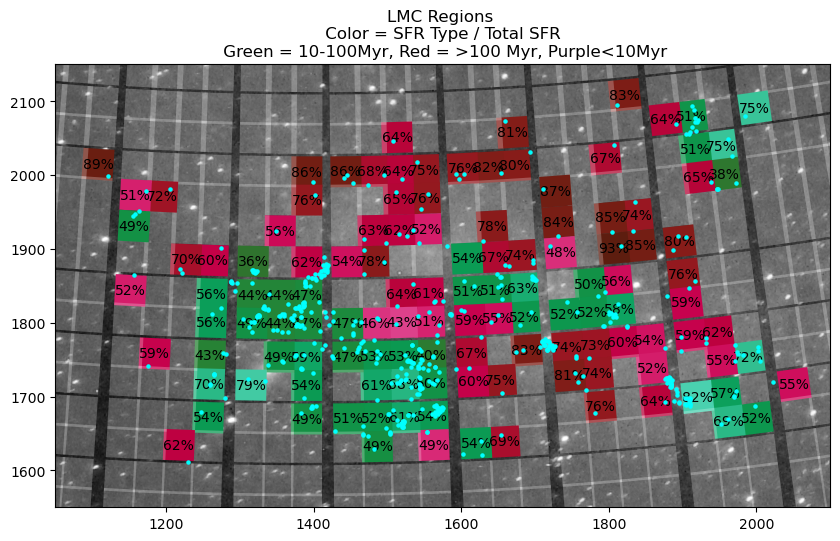

In [41]:
# Lets take a look at the LMC regions visually
f,ax = plt.subplots(figsize=(10,6))
ax.imshow(lmc_img,cmap='gray',origin='lower')
ax.scatter(lmc_x,lmc_y,s=5,color='cyan',alpha=1,zorder=100)

# Create colors that range based on young/old columns
younger_cmap = cmr.get_sub_cmap('cmr.amethyst',0.2,0.92)
target_cmap = cmr.get_sub_cmap('cmr.emerald',0.2,1)
older_cmap = cmr.get_sub_cmap('cmr.flamingo_r',0.12,0.8)

for region_pixel,indrow in zip(lmc_cells,lmc_sfr.iterrows()):
    ind, row = indrow
    n_candidates = row['N_Candidates']

    dominant = row['Dominant']
    if n_candidates == 0:
        region_pixel.plot(ax=ax,edgecolor='white',facecolor='white',fill=True,lw=0.05,alpha=0.25)

    else:
        if dominant == 'Target':
            percent = row['Target_Percent']
            color = target_cmap(percent/100)
        elif dominant == 'Older':
            percent = row['Old_Percent']
            color = older_cmap(percent/100)
        elif dominant == 'Very_Young':
            percent = row['Very_Young_Percent']
            color = younger_cmap(percent/100)

        ax.text(region_pixel.center.x, region_pixel.center.y, f'{percent:.0f}%', color='black', fontsize=10, ha='center', va='center')
        region_pixel.plot(ax=ax,edgecolor=color,facecolor=color,lw=0.05,alpha=1,fill=True)

ax.set_ylim(1550,2150)
ax.set_xlim(1050,2100)
ax.set_title('LMC Regions \n Color = SFR Type / Total SFR \n Green = 10-100Myr, Red = >100 Myr, Purple<10Myr',fontsize=12);

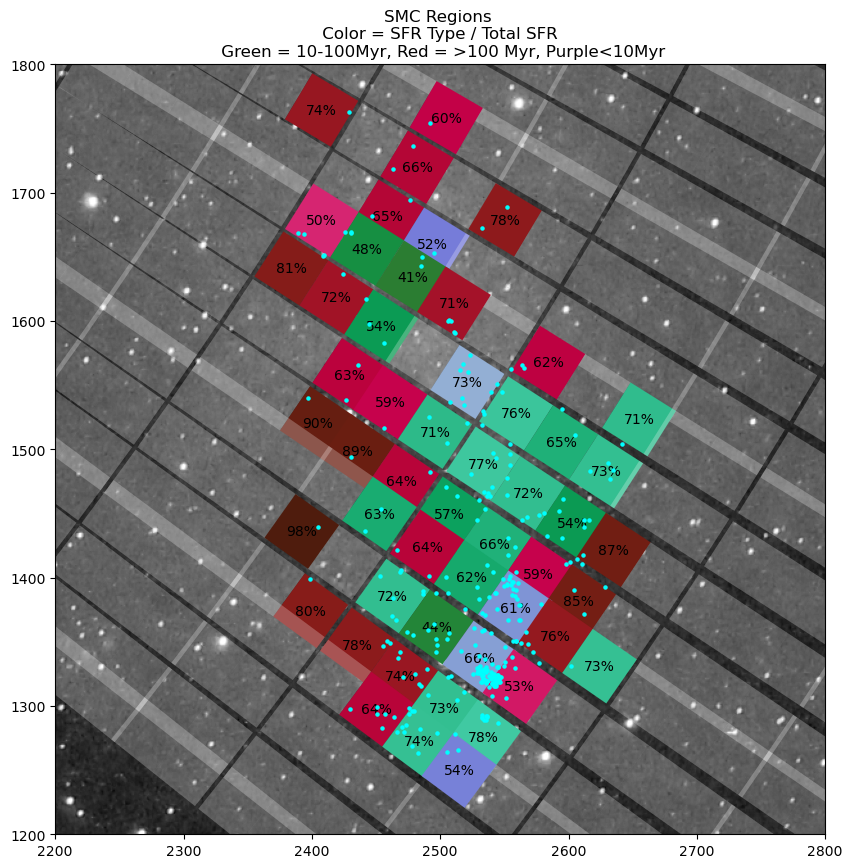

In [47]:
# For the SMC
f,ax = plt.subplots(figsize=(10,10))
ax.imshow(smc_img,cmap='gray',origin='lower')
ax.scatter(smc_x,smc_y,s=5,color='cyan',alpha=1,zorder=100)


for region_pixel,indrow in zip(smc_cells,smc_sfr.iterrows()):
    ind, row = indrow
    n_candidates = row['N_Candidates']
    dominant = row['Dominant']
    
    if n_candidates == 0:
        region_pixel.plot(ax=ax,edgecolor='white',facecolor='white',fill=True,lw=0.05,alpha=0.25)
    else:
        if dominant == 'Target':
            percent = row['Target_Percent']
            color = target_cmap(percent/100)
        elif dominant == 'Older':
            percent = row['Older_Percent']
            color = older_cmap(percent/100)
        elif dominant == 'Younger':
            percent = row['Younger_Percent']
            color = younger_cmap(percent/100)

        ax.text(region_pixel.center.x, region_pixel.center.y, f'{percent:.0f}%', color='black', fontsize=10, ha='center', va='center')
        region_pixel.plot(ax=ax,edgecolor=color,facecolor=color,lw=0.05,alpha=1,fill=True)
ax.set_ylim(1200,1800)
ax.set_xlim(2200,2800)
ax.set_title('SMC Regions \n Color = SFR Type / Total SFR \n Green = 10-100Myr, Red = >100 Myr, Purple<10Myr',fontsize=12);
